# Recommendation Systems

# I. Warnings Omitting

In [1]:
import warnings
warnings.simplefilter(action='ignore')

## II. Imports

In [2]:
import random
import numpy as np
import pandas as pd

In [3]:
from scipy.sparse import csr_matrix

In [4]:
from sklearn.neighbors import NearestNeighbors

# 1. Data Loading and exploration

In [5]:
df_ratings = pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv")
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
df_movies = pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv")
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
n_movies = df_movies.movieId.unique().shape[0]
n_users = df_ratings.userId.unique().shape[0]
n_ratings = df_ratings.shape[0]
print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9742
Number of unique users: 610
Average ratings per user: 165.3
Average ratings per movie: 10.35


In [8]:
df_user_freq = df_ratings[['userId', 'movieId']].groupby('userId').count().reset_index()
df_user_freq.columns = ['userId', 'n_ratings']
df_user_freq

,userId,n_ratings
0,1,232
1,2,29
2,3,39
3,4,216
4,5,44
...,...,...
605,606,1115
606,607,187
607,608,831
608,609,37


# 2. Simple Recommender

In [9]:
df_mean_ratings = df_ratings.groupby('movieId')[['rating']].mean()
df_mean_ratings

,rating
movieId,
1,3.920930
2,3.431818
3,3.259615
4,2.357143
5,3.071429
...,...
193581,4.000000
193583,3.500000
193585,3.500000


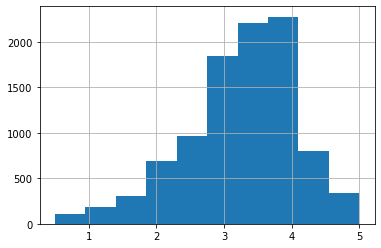

In [10]:
df_mean_ratings['rating'].hist();

In [11]:
# get the lowest rated movies details
df_lowest_rated = df_mean_ratings[df_mean_ratings['rating'] == df_ratings['rating'].min()]
df_lowest_rated = df_lowest_rated.merge(df_movies, on='movieId').reset_index(drop=True)
df_lowest_rated

,movieId,rating,title,genres
0,3604,0.5,Gypsy (1962),Musical
1,3933,0.5,"Killer Shrews, The (1959)",Horror|Sci-Fi
2,4051,0.5,Horrors of Spider Island (Ein Toter Hing im Ne...,Horror|Sci-Fi
3,4371,0.5,Baby Boy (2001),Crime|Drama
4,4580,0.5,Cyborg (1989),Action|Sci-Fi
...,...,...,...,...
91,165645,0.5,Bad Santa 2 (2016),Comedy
92,167296,0.5,Iron Man (1931),Drama
93,173307,0.5,The Gracefield Incident (2015),Action|Horror|Sci-Fi
94,175475,0.5,The Emoji Movie (2017),Animation|Children|Comedy


In [12]:
# get the highest rated movies details
df_highest_rated = df_mean_ratings[df_mean_ratings['rating'] == df_ratings['rating'].max()]
df_highest_rated = df_highest_rated.merge(df_movies, on='movieId').reset_index(drop=True)
df_highest_rated

,movieId,rating,title,genres
0,53,5.0,Lamerica (1994),Adventure|Drama
1,99,5.0,Heidi Fleiss: Hollywood Madam (1995),Documentary
2,148,5.0,"Awfully Big Adventure, An (1995)",Drama
3,467,5.0,Live Nude Girls (1995),Comedy
4,495,5.0,In the Realm of the Senses (Ai no corrida) (1976),Drama
...,...,...,...,...
291,176601,5.0,Black Mirror,(no genres listed)
292,179133,5.0,Loving Vincent (2017),Animation|Crime|Drama
293,179135,5.0,Blue Planet II (2017),Documentary
294,184245,5.0,De platte jungle (1978),Documentary


# 3. Collaborative Filtering

# 3.1. Create a sparse matrix of users and movies

In [13]:
N = len(df_ratings['userId'].unique())
M = len(df_ratings['movieId'].unique())
print(f"Number of users: {N}")
print(f"Number of movies: {M}")

Number of users: 610
Number of movies: 9724


In [14]:
user_mapper = dict(zip(np.unique(df_ratings["userId"]), list(range(N))))
movie_mapper = dict(zip(np.unique(df_ratings["movieId"]), list(range(M))))

In [15]:
user_mapper

{1: 0,
 2: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 9: 8,
 10: 9,
 11: 10,
 12: 11,
 13: 12,
 14: 13,
 15: 14,
 16: 15,
 17: 16,
 18: 17,
 19: 18,
 20: 19,
 21: 20,
 22: 21,
 23: 22,
 24: 23,
 25: 24,
 26: 25,
 27: 26,
 28: 27,
 29: 28,
 30: 29,
 31: 30,
 32: 31,
 33: 32,
 34: 33,
 35: 34,
 36: 35,
 37: 36,
 38: 37,
 39: 38,
 40: 39,
 41: 40,
 42: 41,
 43: 42,
 44: 43,
 45: 44,
 46: 45,
 47: 46,
 48: 47,
 49: 48,
 50: 49,
 51: 50,
 52: 51,
 53: 52,
 54: 53,
 55: 54,
 56: 55,
 57: 56,
 58: 57,
 59: 58,
 60: 59,
 61: 60,
 62: 61,
 63: 62,
 64: 63,
 65: 64,
 66: 65,
 67: 66,
 68: 67,
 69: 68,
 70: 69,
 71: 70,
 72: 71,
 73: 72,
 74: 73,
 75: 74,
 76: 75,
 77: 76,
 78: 77,
 79: 78,
 80: 79,
 81: 80,
 82: 81,
 83: 82,
 84: 83,
 85: 84,
 86: 85,
 87: 86,
 88: 87,
 89: 88,
 90: 89,
 91: 90,
 92: 91,
 93: 92,
 94: 93,
 95: 94,
 96: 95,
 97: 96,
 98: 97,
 99: 98,
 100: 99,
 101: 100,
 102: 101,
 103: 102,
 104: 103,
 105: 104,
 106: 105,
 107: 106,
 108: 107,
 109: 108,
 110: 109,
 111: 11

In [16]:
movie_mapper

{1: 0,
 2: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 9: 8,
 10: 9,
 11: 10,
 12: 11,
 13: 12,
 14: 13,
 15: 14,
 16: 15,
 17: 16,
 18: 17,
 19: 18,
 20: 19,
 21: 20,
 22: 21,
 23: 22,
 24: 23,
 25: 24,
 26: 25,
 27: 26,
 28: 27,
 29: 28,
 30: 29,
 31: 30,
 32: 31,
 34: 32,
 36: 33,
 38: 34,
 39: 35,
 40: 36,
 41: 37,
 42: 38,
 43: 39,
 44: 40,
 45: 41,
 46: 42,
 47: 43,
 48: 44,
 49: 45,
 50: 46,
 52: 47,
 53: 48,
 54: 49,
 55: 50,
 57: 51,
 58: 52,
 60: 53,
 61: 54,
 62: 55,
 63: 56,
 64: 57,
 65: 58,
 66: 59,
 68: 60,
 69: 61,
 70: 62,
 71: 63,
 72: 64,
 73: 65,
 74: 66,
 75: 67,
 76: 68,
 77: 69,
 78: 70,
 79: 71,
 80: 72,
 81: 73,
 82: 74,
 83: 75,
 85: 76,
 86: 77,
 87: 78,
 88: 79,
 89: 80,
 92: 81,
 93: 82,
 94: 83,
 95: 84,
 96: 85,
 97: 86,
 99: 87,
 100: 88,
 101: 89,
 102: 90,
 103: 91,
 104: 92,
 105: 93,
 106: 94,
 107: 95,
 108: 96,
 110: 97,
 111: 98,
 112: 99,
 113: 100,
 116: 101,
 117: 102,
 118: 103,
 119: 104,
 121: 105,
 122: 106,
 123: 107,
 125: 108,
 126: 10

In [17]:
user_index = [user_mapper[i] for i in df_ratings['userId']]
movie_index = [movie_mapper[i] for i in df_ratings['movieId']]
X = csr_matrix((df_ratings["rating"], (movie_index, user_index)), shape=(M, N))
df_X = pd.DataFrame(X.toarray())
df_X

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
1,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 3.2. Find similar movies

# 3.2.1. Prepare the model

In [18]:
movie_id = random.randint(0, n_movies)
df_movies.loc[df_movies['movieId']==df_ratings['movieId'].unique()[movie_id]]

,movieId,title,genres
7845,93510,21 Jump Street (2012),Action|Comedy|Crime


In [19]:
neighbor_ids = []

movie_idx = movie_mapper[movie_id]
movie_vec = X[movie_idx]
k=10
knn = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric="cosine")
knn.fit(X)
movie_vec = movie_vec.reshape(1,-1)
neighbor = knn.kneighbors(movie_vec, return_distance=False)

movie_inv_mapper = dict(zip(list(range(M)), np.unique(df_ratings["movieId"])))

for i in range(0,k):
    n = neighbor.item(i)
    neighbor_ids.append(movie_inv_mapper[n])
neighbor_ids.pop(0)
neighbor_ids

[1187, 3217, 7216, 2067, 2132, 1683, 3735, 8364, 1299]

In [20]:
def find_similar_movies(movie_id, X, k):

    neighbor_ids = []

    movie_idx = movie_mapper[movie_id]
    movie_vec = X[movie_idx]
    k=k+1
    knn = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric="cosine")
    knn.fit(X)
    movie_vec = movie_vec.reshape(1,-1)
    neighbor = knn.kneighbors(movie_vec, return_distance=False)

    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df_ratings["movieId"])))

    for i in range(0,k):
        n = neighbor.item(i)
        neighbor_ids.append(movie_inv_mapper[n])
    neighbor_ids.pop(0)
    return neighbor_ids

In [21]:
movie_titles = dict(zip(df_movies['movieId'], df_movies['title']))
movie_titles

{1: 'Toy Story (1995)',
 2: 'Jumanji (1995)',
 3: 'Grumpier Old Men (1995)',
 4: 'Waiting to Exhale (1995)',
 5: 'Father of the Bride Part II (1995)',
 6: 'Heat (1995)',
 7: 'Sabrina (1995)',
 8: 'Tom and Huck (1995)',
 9: 'Sudden Death (1995)',
 10: 'GoldenEye (1995)',
 11: 'American President, The (1995)',
 12: 'Dracula: Dead and Loving It (1995)',
 13: 'Balto (1995)',
 14: 'Nixon (1995)',
 15: 'Cutthroat Island (1995)',
 16: 'Casino (1995)',
 17: 'Sense and Sensibility (1995)',
 18: 'Four Rooms (1995)',
 19: 'Ace Ventura: When Nature Calls (1995)',
 20: 'Money Train (1995)',
 21: 'Get Shorty (1995)',
 22: 'Copycat (1995)',
 23: 'Assassins (1995)',
 24: 'Powder (1995)',
 25: 'Leaving Las Vegas (1995)',
 26: 'Othello (1995)',
 27: 'Now and Then (1995)',
 28: 'Persuasion (1995)',
 29: 'City of Lost Children, The (Cité des enfants perdus, La) (1995)',
 30: 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 31: 'Dangerous Minds (1995)',
 32: 'Twelve Monkeys (a.k.a. 12 Monkeys) (199

# 3.2.2. Find similar movies

In [22]:
movie_id = 586
movie_title = movie_titles[movie_id]
movie_title

'Home Alone (1990)'

In [23]:
similar_ids = find_similar_movies(movie_id, X, k=10)

print(f"Since you watched: {movie_title}")
print(similar_ids)
for i in similar_ids:
    print(movie_titles[i])

Since you watched: Home Alone (1990)
[500, 364, 597, 480, 2, 377, 356, 588, 367, 2115]
Mrs. Doubtfire (1993)
Lion King, The (1994)
Pretty Woman (1990)
Jurassic Park (1993)
Jumanji (1995)
Speed (1994)
Forrest Gump (1994)
Aladdin (1992)
Mask, The (1994)
Indiana Jones and the Temple of Doom (1984)


In [26]:
rated = df_ratings.loc[df_ratings['movieId']==movie_id]
rated

,userId,movieId,rating,timestamp
1067,8,586,3.0,839463702
1428,14,586,3.0,835441451
1820,18,586,3.5,1455748696
2393,19,586,3.0,965707079
2991,20,586,3.0,1054038279
...,...,...,...,...
91378,592,586,4.0,837350242
91542,594,586,5.0,1109036952
92867,599,586,3.0,1498525239
96084,602,586,1.0,840875757


# 3.3. Handling users bias

In [27]:
df_X_T = df_X.T.copy()
df_X_T['userBias'] = df_X_T[df_X_T!=0].mean(numeric_only=True, axis=1)
df_X_T

,0,1,2,3,4,5,6,7,8,9,...,9715,9716,9717,9718,9719,9720,9721,9722,9723,userBias
0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.366379
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.948276
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.435897
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.555556
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.636364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.657399
606,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.786096
607,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.134176
608,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.270270


In [28]:
usrBias = df_X_T.iloc[rated["userId"].values]["userBias"]
usrBias = usrBias.reset_index(drop=True)
usrBias

0      3.260870
1      3.448148
2      2.607397
3      3.590909
4      3.260722
         ...   
111    3.266990
112    4.200000
113    2.991481
114    3.507953
115    3.270270
Name: userBias, Length: 116, dtype: float64

In [29]:
df_rated = rated.reset_index(drop=True)
df_rated

,userId,movieId,rating,timestamp
0,8,586,3.0,839463702
1,14,586,3.0,835441451
2,18,586,3.5,1455748696
3,19,586,3.0,965707079
4,20,586,3.0,1054038279
...,...,...,...,...
111,592,586,4.0,837350242
112,594,586,5.0,1109036952
113,599,586,3.0,1498525239
114,602,586,1.0,840875757


In [30]:
filtering = df_rated["rating"]>=usrBias
filtering

0      False
1      False
2       True
3      False
4      False
       ...  
111     True
112     True
113     True
114    False
115    False
Length: 116, dtype: bool

In [31]:
recommend = df_rated.loc[filtering]

print(recommend)

     userId  movieId  rating   timestamp
2        18      586     3.5  1455748696
10       62      586     4.0  1521489913
19      102      586     4.0   835877270
20      103      586     4.0  1431957135
23      116      586     3.5  1337199910
24      117      586     4.0   844162913
30      169      586     5.0  1078284644
38      220      586     4.5  1230061714
40      229      586     3.0   838143590
50      280      586     4.0  1348532002
54      292      586     4.0  1265680476
56      304      586     4.0   891173994
59      322      586     3.5  1217676382
62      344      586     5.0  1420496646
65      357      586     4.0  1348612117
68      380      586     4.0  1494803432
73      402      586     4.0   849601295
74      411      586     4.0   835532644
79      436      586     4.0   833530512
85      475      586     4.5  1498031682
87      477      586     3.0  1200939829
88      480      586     4.0  1179177983
90      484      586     4.0  1342296049
92      491     

# 4. Exercise

## 1. Get the Musical Instruments Ratings dataset from: http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Musical_Instruments.csv
## 2. Create a simple recommender system that recommends the highest rated instruments
## 3. Create a collaborative filtering system that recommends similar instruments to the one given
## 4. Explore and handle the user bias if needed

### TIP: You can read the dataset using the following code:

In [ ]:
df_music_instruments = pd.read_csv('http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Musical_Instruments.csv', header=None)
df_music_instruments.columns = ['userId', 'productId', 'rating', 'timestamp']

In [ ]:
df_music_instruments